# Processamento de Imagem Digital

## Trabalho 3

### Introdução

O trabalho tem por objetivo implementar técnicas de alinhamento automático de imagens.

Típicamente, quando documentos físicos são digitalizados, o documento não estará alinhado com o eixo do digitalizador, gerando imagens desalinhadas que podem apresentar características indesejadas, como incomodo para humanos e baixa susceptibilidade a técnicas de reconhecimento ótico de caracteres (OCR).

Dessa forma, ser capaz de alinhar imagens digitalizadas é uma etapa importante tanto para o armazenamento de imagens humanamente valiosas, quanto para a digitalização de dados em documentos físicos. A automatização deste alinhamento, em conjunto com a técnica de OCR e outras técnicas de extração de informação em texto podem permitir a automatização completa da digitalização de dados em certos conjuntos de documentos.

Tal tecnologia torna o processo de digitalização eficiente e abre portas para inúmeras aplicações de amplo interesse no mercado e na sociedade. Entre essas aplicações, é possível destacas exemplos como a construção de bases de conhecimento de quadros clinícos para estudo médico através da digitalização de prontuários, e a automatização da avaliação de imóveis estressados através da digitalização de escrituras, registros e certidões.

Testaremos duas técnicas: uma baseada em projeção horizontal e outra em transformada de Hough. Em ambos os casos, iremos assumir que as componentes de alta frequência da imagem do documento são majoritariamente texto (ou partituras). Desse modo, teremos como premissa que o número de pixeis colineares na projeção horizontal da imagem é máximo quando o documento está alinhado ao do eixo digitalizador. Note que essa premissa não se sustenta para qualquer imagem, mas deve ser válida para documentos digitalizados quando conseguimos selecionar texto com técnicas de extração de bordas.

### Preparação

#### Requisitos

In [38]:
# Conetando ao google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
# Importando pacotes que serão utilizados
import cv2
import matplotlib.pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow
from scipy.stats import mode
from skimage.filters import sobel, threshold_local
from skimage.transform import hough_line, hough_line_peaks, rotate

#### Imagens

Para validar os algoritmos desenvolvidos, várias características são importantes. Entre elas, a capacidade de generalização, ou seja, de solucionar o problema para diferentes ângulos e tipos de documento.

Serão utilizadas todas as imagens disponibilizadas pelo professor em seu [repositório de imagens inclinadas em png](https://www.ic.unicamp.br/~helio/imagens_inclinadas_png/) e imagens geradas sintéticamente a partir destas.

In [40]:
# Carregando imagem do drive em escala de cinza
images = {
    "neg_28": cv2.imread("/content/drive/MyDrive/MC920/T3/neg_28.png", cv2.IMREAD_GRAYSCALE),
    "neg_4": cv2.imread("/content/drive/MyDrive/MC920/T3/neg_4.png", cv2.IMREAD_GRAYSCALE),
    "partitura": cv2.imread("/content/drive/MyDrive/MC920/T3/partitura.png", cv2.IMREAD_GRAYSCALE),
    "pos_24": cv2.imread("/content/drive/MyDrive/MC920/T3/pos_24.png", cv2.IMREAD_GRAYSCALE),
    "pos_41": cv2.imread("/content/drive/MyDrive/MC920/T3/pos_41.png", cv2.IMREAD_GRAYSCALE),
    "sample1": cv2.imread("/content/drive/MyDrive/MC920/T3/sample1.png", cv2.IMREAD_GRAYSCALE),
    "sample2": cv2.imread("/content/drive/MyDrive/MC920/T3/sample2.png", cv2.IMREAD_GRAYSCALE),
}

for name, image in images.items():
    print(f"Imagem `{name}` tem dimensões {image.shape} e tons de cinza armazenados em inteiros {image.dtype}")

Imagem `neg_28` tem dimensões (525, 660) e tons de cinza armazenados em inteiros uint8
Imagem `neg_4` tem dimensões (317, 620) e tons de cinza armazenados em inteiros uint8
Imagem `partitura` tem dimensões (394, 223) e tons de cinza armazenados em inteiros uint8
Imagem `pos_24` tem dimensões (495, 662) e tons de cinza armazenados em inteiros uint8
Imagem `pos_41` tem dimensões (601, 634) e tons de cinza armazenados em inteiros uint8
Imagem `sample1` tem dimensões (184, 300) e tons de cinza armazenados em inteiros uint8
Imagem `sample2` tem dimensões (1024, 727) e tons de cinza armazenados em inteiros uint8


Adicionalmente, introduziremos 2 amostras sintéticas, geradas ao se rotacionar exemplos anteriores em 180 graus, de modo a testar os quatro quadrantes possíveis para rotação.

In [41]:
images["neg_208"] = rotate(images["neg_28"], 180)
images["pos_204"] = rotate(images["pos_24"], -180)

As principais imagens utilizas serão a "neg_28", "pos_24", "neg_208" e "pos_204" de modo a facilitar a interpretação dos resultados, mas todas serão exploradas em experimentos nas seções posteriores.

(-0.5, 659.5, 524.5, -0.5)

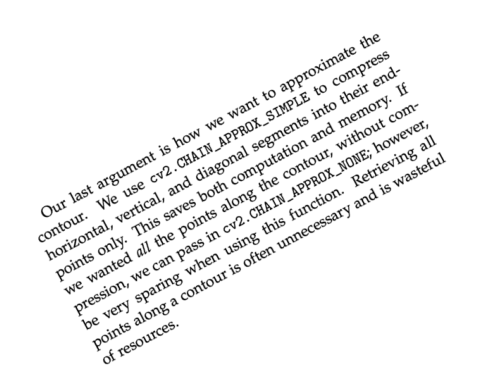

In [42]:
plt.imshow(images["neg_28"], cmap="gray")
plt.axis('off')

(-0.5, 659.5, 524.5, -0.5)

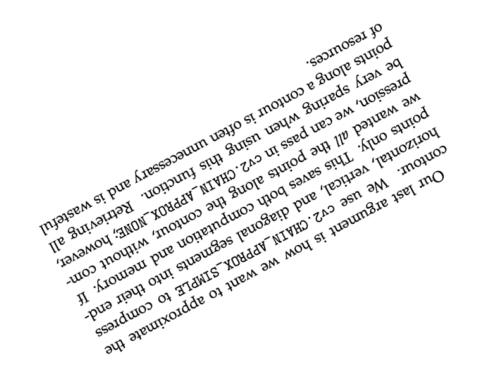

In [43]:
plt.imshow(images["neg_208"], cmap="gray")
plt.axis('off')

(-0.5, 661.5, 494.5, -0.5)

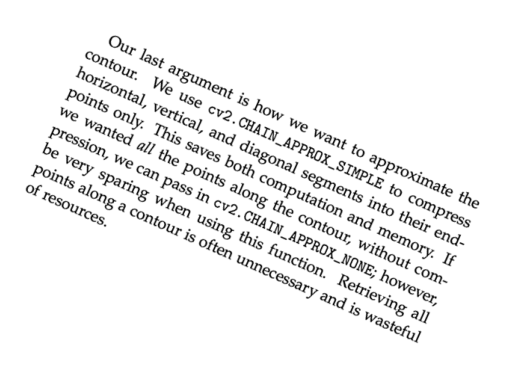

In [44]:
plt.imshow(images["pos_24"], cmap="gray")
plt.axis('off')

(-0.5, 661.5, 494.5, -0.5)

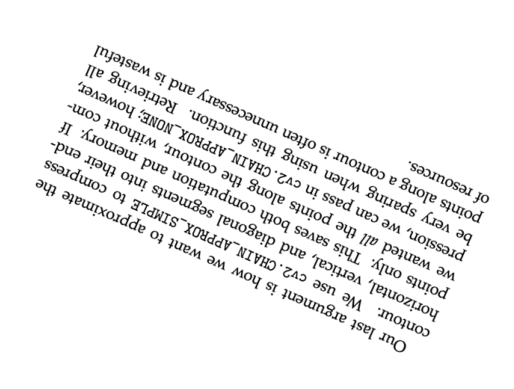

In [45]:
plt.imshow(images["pos_204"], cmap="gray")
plt.axis('off')

### Transformada de Hough

A transformada de Hough é um artifício matemático que permite a identificação de curvas parametrizáveis em imagens binárias digitais.

O algoritmo de alinhamento utiliza a premissa de que o número de pixeis colineares na projeção horizontal da imagem é máximo quando o documento está alinhado ao do eixo digitalizador para justificar a escolha do ângulo de alinhamento através da extração do ângulo mais frequente em retas reconhecidas na imagem pela transformada.

Ou seja, para alinhar uma imagem, seguimos os seguintes passos:

1. Pré-processamos a imagem para extrair bordas e binarizar.
2. Extraimos o valor theta mais frequente nas retas encontradas através da transformada de Hough.
3. Alinhamos a imagem original baseado no ângulo theta encontrado.

#### Pré-processamento

As imagens de exemplo serem bastante simples, com poucas texturas, o bom funcionamento dos algoritmos de alinhamento depende de um pré-processamento capaz de destacar texto e linhas nas imagens.

Ou seja, ambos os métodos que utilizaremos se beneficiam de imagens pré-processadas para extração das componenentes de maior frequência que contém os caracteres de interesse. Esse comportamento ficaria ainda mais evidente em uma imagem de um documento mais complexo, com marca d'água ou outros padrões, como, por exemplo, uma carteira de motorista.

Portanto, implementaremos um pré-processamento básico para simplificação da imagem.

O pré-processamento tem por objetivo extrair bordas (em especial caracteres) da imagem e binarizá-la de modo a habilitar as ténicas posteriores. Para tal, teremos 2 passos:

1. Aplicamos o filtro passa alta de Sobel para extração das bordas.
2. Transformamos a imagem em uma imagem binária com limiarização local.

In [46]:
borders = sobel(images["neg_28"])

(-0.5, 659.5, 524.5, -0.5)

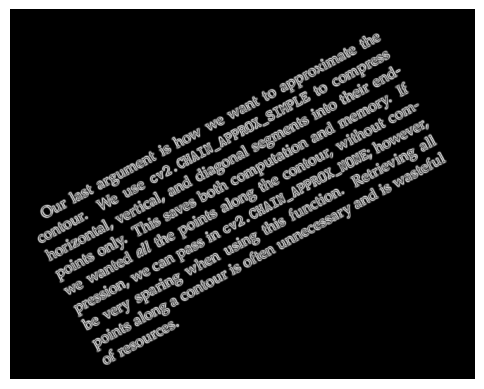

In [47]:
plt.imshow(borders, cmap='gray')
plt.axis('off')

In [48]:
threshold = threshold_local(borders, 99)
binary_image = borders > threshold

(-0.5, 659.5, 524.5, -0.5)

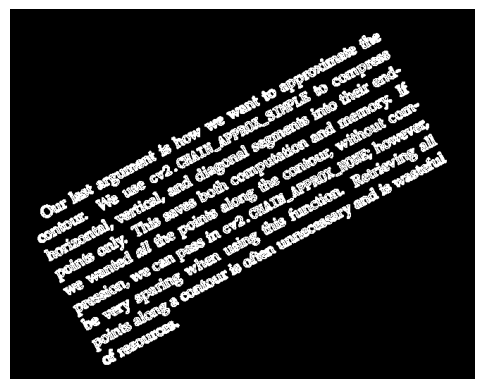

In [49]:
plt.imshow(binary_image, cmap='gray')
plt.axis('off')

In [50]:
preprocessed = binary_image

#### Intuição

Com a imagem pré-processada, aplicamos a transformada de Hough para a detecção de retas e selecionamos o ângulo theta mais frequente.

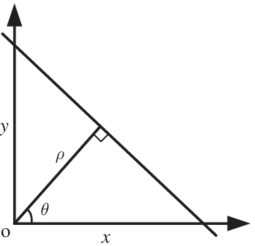

Note, entretanto, que o ângulo theta mais frequente é perpendicular ao ângulo de alinhamento.

In [51]:
# https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.hough_line

# Calculamos a transformada de Hough
hspace, angles, distances = hough_line(preprocessed)

# Escolhemos apenas os picos na transformada
hspace, angles, distances = hough_line_peaks(hspace, angles, distances)

# Escolhemos o angulo mais frequente (moda)
rad_angle = mode(angles)[0]

# Convertemos de radiano para graus
deg_angle = np.rad2deg(rad_angle)

Note que quando aplicamos a transformada de Hough para linhas, múltiplas retas serão detectadas, inclusive em ângulos distintos do desejado. Entretanto, como assumimos que a colineariedade é máxima quando a imagem está alinhada com o eixo do digitalizador, faremos uma votação (tomaremos a moda dos ângulos de maior intensidade) para decidir o ângulo.

In [52]:
deg_angle

62.000000000000014

Agora, basta rotacionar a imagem original adequadamente com relação ao ângulo encontrado.

In [53]:
# Queremos o angulo pelo qual, quando rotacionarmos a imagem original, teremos a imagem alinhada
rotation_angle = deg_angle + 90 if deg_angle < 0 else deg_angle - 90

Existem efeitos colaterais de perda de informaçõ devido a rotações. Portanto, iremos redimensionar as imagens de maneira que a imagen rotacionada contenha a imagem original inteira.

In [54]:
output = rotate(images["neg_28"], rotation_angle, resize=True)

Verificando o resultado:

(-0.5, 828.5, 772.5, -0.5)

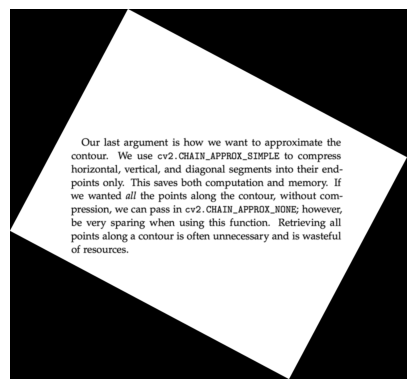

In [55]:
plt.imshow(output, cmap='gray')
plt.axis('off')

Como esperado, obtivemos um bom alinhamento.

#### Generalização

Agora, generalizando o conjunto de operações que fizemos:

In [56]:
class HoughAligner:

    def preprocess(self, image):
        borders = sobel(image)

        threshold = threshold_local(borders, 99)
        binary_image = borders > threshold

        return binary_image

    def find_rotation_angle(self, preprocessed):
        hspace, angles, distances = hough_line(preprocessed)

        hspace, angles, distances = hough_line_peaks(hspace, angles, distances)

        rad_angle = mode(angles)[0]

        deg_angle = np.rad2deg(rad_angle)

        return deg_angle + 90 if deg_angle < 0 else deg_angle - 90

    def align(self, image):
        preprocessed = self.preprocess(image)
        rotation_angle = self.find_rotation_angle(preprocessed)

        return rotate(image, rotation_angle, resize=True)

hough_aligner = HoughAligner()

#### Testes

(-0.5, 805.5, 720.5, -0.5)

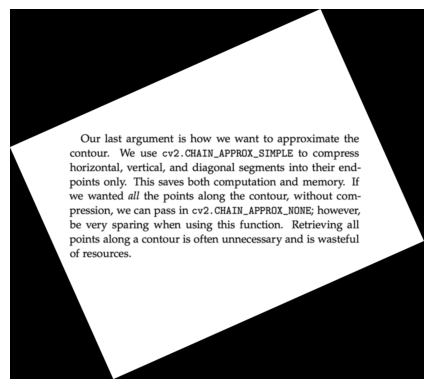

In [57]:
plt.imshow(hough_aligner.align(images["pos_24"]), cmap='gray')
plt.axis('off')

(-0.5, 828.5, 772.5, -0.5)

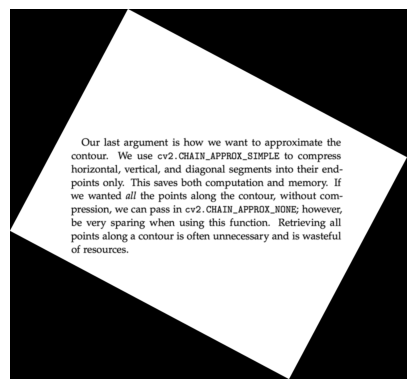

In [58]:
plt.imshow(hough_aligner.align(images["neg_28"]), cmap='gray')
plt.axis('off')

(-0.5, 805.5, 720.5, -0.5)

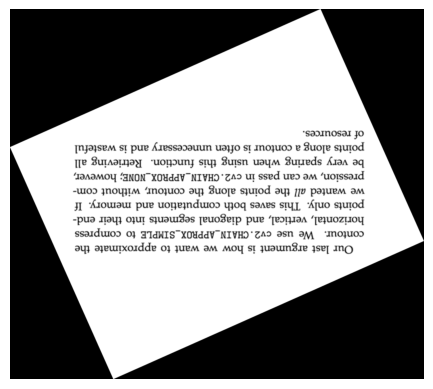

In [59]:
plt.imshow(hough_aligner.align(images["pos_204"]), cmap='gray')
plt.axis('off')

(-0.5, 828.5, 772.5, -0.5)

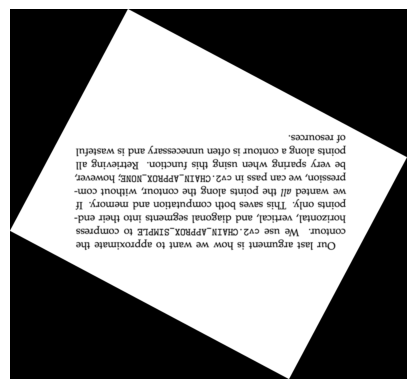

In [60]:
plt.imshow(hough_aligner.align(images["neg_208"]), cmap='gray')
plt.axis('off')

(-0.5, 435.5, 435.5, -0.5)

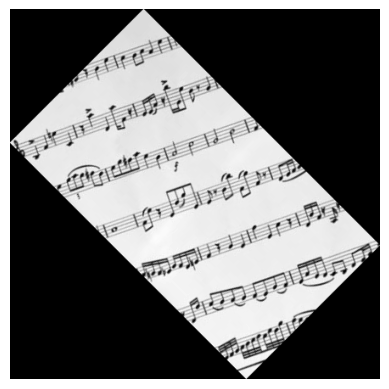

In [61]:
plt.imshow(hough_aligner.align(images["partitura"]), cmap='gray')
plt.axis('off')

(-0.5, 334.5, 250.5, -0.5)

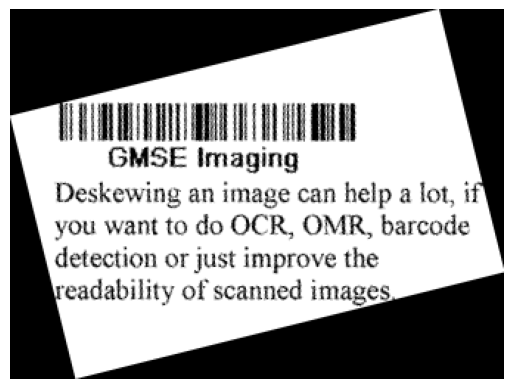

In [62]:
plt.imshow(hough_aligner.align(images["sample1"]), cmap='gray')
plt.axis('off')

(-0.5, 829.5, 1093.5, -0.5)

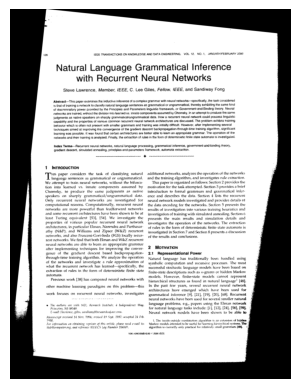

In [63]:
plt.imshow(hough_aligner.align(images["sample2"]), cmap='gray')
plt.axis('off')

Podemos perceber que o alinhador teve boa capacidade de generalização, mas deixou invertidas as imagens nos quadrantes 3 e 4, bem como teve dificuldades com a imagem da partitura.

#### Problemas

(-0.5, 222.5, 393.5, -0.5)

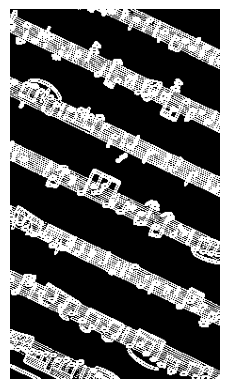

In [64]:
partitura_preprocessed = hough_aligner.preprocess(images["partitura"])

plt.imshow(partitura_preprocessed, cmap='gray')
plt.axis('off')

A priori, o pré-processamento parece estar fazendo um trabalho decente. Então podemos verificar a distribuição de angulos encontrados pela transformada de Hough.

In [65]:
hspace, angles, distances = hough_line(partitura_preprocessed)

hspace, angles, distances = hough_line_peaks(hspace, angles, distances)

from collections import defaultdict

angles_count = defaultdict(lambda :0)
for angle in angles:
    angles_count[angle] += 1

sorted(angles_count.items(), key=lambda item: item[1])[-5:]

[(0.22689280275926293, 2),
 (0.47123889803846897, 3),
 (-1.117010721276371, 5),
 (0.7853981633974483, 6),
 (-0.7853981633974483, 8)]

Podemos ver que os 2 primeiros ângulos na votação são ângulos complementares.

(-0.5, 372.5, 451.5, -0.5)

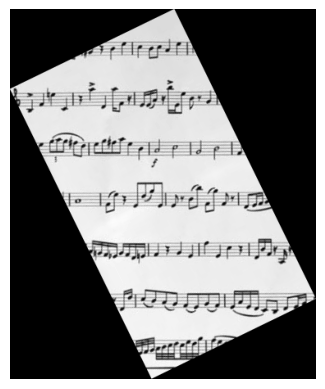

In [75]:
deg_angle = np.rad2deg(-1.117010721276371)
attempt = rotate(images["partitura"], deg_angle + 90, resize=True)

plt.imshow(attempt, cmap='gray')
plt.axis('off')

Utilizando o terceiro colocado na votação, entretanto, temos o resultado desejado. Este resultado pode indicar que a nossa premissa de máxima colinearidade na imagem alinhada ao eixo do digitalizador não se sustenta para esta imagem.

Outra hipótese a ser testada é melhorar ainda mais o pré-processamento ou a extração de linhas pela transformada de Hough.

Mais testes são necessários e talvez a técnica de projeção horizontal nos forneça mais informações.

### Projeção Horizontal

A projeção horizontal é uma técnica de descrição de regiões em imagens binárias.
Dado que os pixels f(x, y) de uma regiãoo possuem valor igual a 1, a projeção horizontal Ph é [definida](https://www.ic.unicamp.br/~helio/disciplinas/MO443/aula_representacao.pdf) como a soma dos pixels existentes em cada linha do objeto:

$Ph(y) = \sum_{x=0}^{M-1} f(x, y)$

O algoritmo de alinhamento utiliza a premissa de que o número de pixeis colineares na projeção horizontal da imagem é máximo quando o documento está alinhado ao do eixo digitalizador para justificar a escolha do ângulo de alinhamento que maximiza uma função objetivo para a colinearidade de pixeis.

Ou seja, para alinhar uma imagem, seguimos os seguintes passos:

1. Pré-processamos a imagem para extrair bordas e binarizar.
2. Encontramos o valor de theta que maximiza a função objetivo.
3. Alinhamos a imagem original baseado no ângulo encontrado.

A função objetivo escolhida foi a soma dos quadrados das diferenças dos valores em células adjacentes do perfil de projeção, como sugerido no enunciado.

In [76]:
class HorizontalProjectionAligner:

    def preprocess(self, image):
        borders = sobel(image)

        threshold = threshold_local(borders, 99)
        binary_image = borders > threshold

        return binary_image

    def fitness(self, rotated):
        profile = rotated.sum(axis=1)
        return np.square(profile - np.roll(profile, 1)).sum()

    def find_rotation_angle(self, preprocessed):
        fitnesses = {}

        for angle in range(-90, 90):
            rotated = rotate(preprocessed, angle)
            fitnesses[angle] = self.fitness(rotated)

        return max(fitnesses.items(), key=lambda item: item[1])[0]

    def align(self, image):
        preprocessed = self.preprocess(image)
        rotation_angle = self.find_rotation_angle(preprocessed)

        return rotate(image, rotation_angle, resize=True)

horizontal_projection_aligner = HorizontalProjectionAligner()

#### Testes

(-0.5, 805.5, 720.5, -0.5)

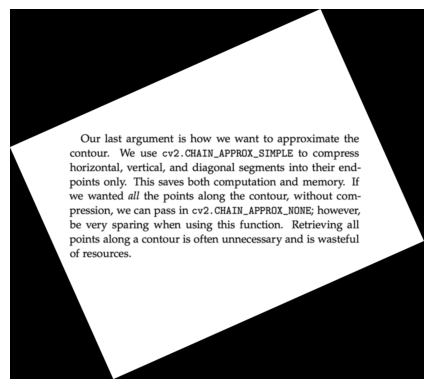

In [77]:
plt.imshow(horizontal_projection_aligner.align(images["pos_24"]), cmap='gray')
plt.axis('off')

(-0.5, 828.5, 772.5, -0.5)

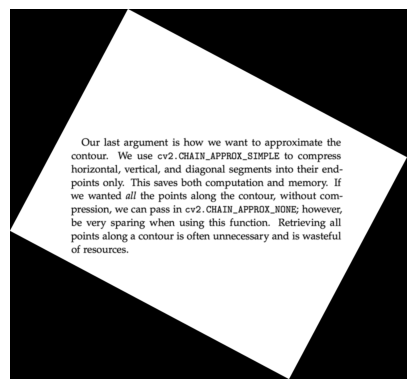

In [78]:
plt.imshow(horizontal_projection_aligner.align(images["neg_28"]), cmap='gray')
plt.axis('off')

(-0.5, 805.5, 720.5, -0.5)

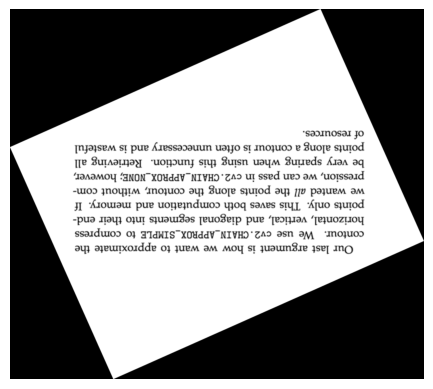

In [79]:
plt.imshow(horizontal_projection_aligner.align(images["pos_204"]), cmap='gray')
plt.axis('off')

(-0.5, 828.5, 772.5, -0.5)

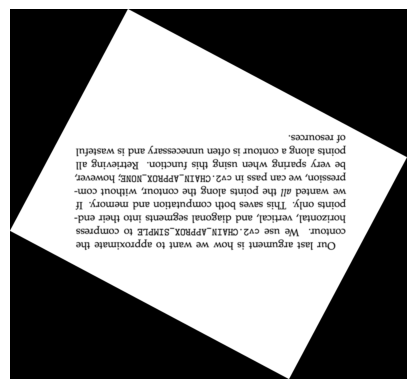

In [80]:
plt.imshow(horizontal_projection_aligner.align(images["neg_208"]), cmap='gray')
plt.axis('off')

(-0.5, 372.5, 451.5, -0.5)

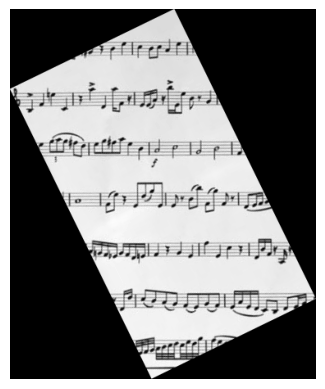

In [81]:
plt.imshow(horizontal_projection_aligner.align(images["partitura"]), cmap='gray')
plt.axis('off')

(-0.5, 334.5, 250.5, -0.5)

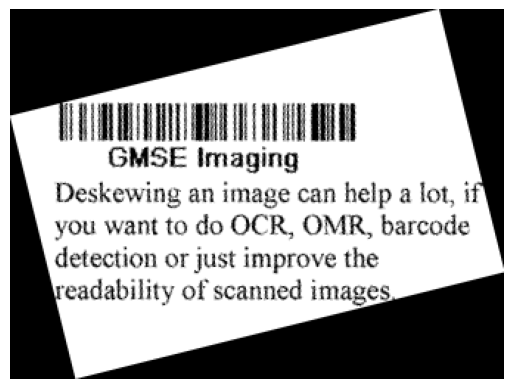

In [82]:
plt.imshow(horizontal_projection_aligner.align(images["sample1"]), cmap='gray')
plt.axis('off')

(-0.5, 829.5, 1093.5, -0.5)

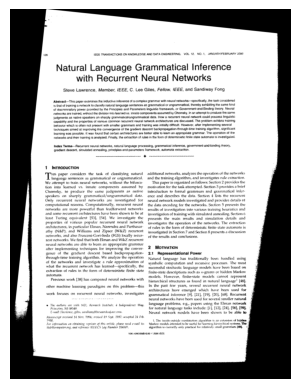

In [83]:
plt.imshow(horizontal_projection_aligner.align(images["sample2"]), cmap='gray')
plt.axis('off')

Os resultado obtidos foram excelentes, tendo alinhado corretamente em todos os casos.

Com esta técnica, fica claro que o pré-processamento está bom o suficiente e o problema da outra técnica está na extração de retas pela transformada de Hough. Mais testes com o threshold de seleção de picos devem ser feitos para garantir o sucesso da aplicação da técnica.

É importante salientar que para garantir o funcionamento geral, alinhando corretamente imagens nos quadrantes 3 e 4, seria necessário a aplicação de um segundo teste como, por exemplo, a aplicação de um algoritmo de OCR na imagem rotacionada pelo ângulo originalmente encontrado e pelo ângulo encontrado + 180º, escolhendo o que obtivesse melhor resultado no teste.